## Setup

In [111]:
# imports
import os, threadpoolctl, psycopg2, pandas as pd, numpy as np, math, seaborn as sns, matplotlib.pyplot as plt, matplotlib.cm as cm, hvplot.pandas
from dotenv import load_dotenv
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Literal, Tuple, Union, Sequence

In [112]:
# stop leak message from modeling
os.environ['OMP_NUM_THREADS'] = '1'
threadpoolctl.threadpool_limits(1)

In [113]:
# database setup
db = 'order_mgmt'

# pull credentials from .env
load_dotenv('../.env')

dsn = f'''
dbname={db} 
user={os.getenv('super_user')} 
password={os.getenv('pg_password')} 
host={os.getenv('host')} 
port={os.getenv('port')}
'''

### Get data from database

In [114]:
# connect to database to create dataframe
with psycopg2.connect(dsn) as conn, conn.cursor() as cur:
    # get one record per purchase
    cur.execute(
        '''
        SELECT 	o.order_no,
		        o.customer_id,
                o.order_date,
                SUM(ol.sales) AS total_sales
        FROM orders o
        JOIN order_lines ol USING (order_no)
        WHERE o.status IN 
            ('Shipped', 'Resolved')
        GROUP BY o.order_no, o.customer_id, o.order_date
        ORDER BY o.order_no
        '''
    )

    # fetch data
    records = cur.fetchall()
    fields = [field.name for field in cur.description]

    # setup dataframe
    df = pd.DataFrame(records, columns=fields)

In [115]:
# display data
df.head()

,order_no,customer_id,order_date,total_sales
0,10100,15,2003-01-06,12133.25
1,10101,51,2003-01-09,11432.34
2,10102,42,2003-01-10,6864.05
3,10103,65,2003-01-29,54702.00
4,10104,37,2003-01-31,44621.96


# Preprocessing
---

## Update data types

In [116]:
# data types
df.dtypes

order_no        int64
customer_id     int64
order_date     object
total_sales    object
dtype: object

In [117]:
# update data types
df.total_sales = pd.to_numeric(df.total_sales)
df.order_date = pd.to_datetime(df.order_date)

In [118]:
# double check dtypes
df.dtypes

order_no                int64
customer_id             int64
order_date     datetime64[ns]
total_sales           float64
dtype: object

## Get dates (lifetime)

In [119]:
# capture dates
recent_date = df.order_date.max()
oldest_date = df.order_date.min()

print(f'Date range: {oldest_date} - {recent_date}')

Date range: 2003-01-06 00:00:00 - 2005-05-17 00:00:00


In [120]:
# store decided date range
rfm_date_range = {
    'start_date': oldest_date.date().isoformat(),
    'end_date': recent_date.date().isoformat()
}

%store rfm_date_range

Stored 'rfm_date_range' (dict)


## Get RFM (Recency, Frequency, Monetary)

For each customer:
- Recency: number of days between "present" date and date of last purchase
- Frequency: number of orders
- Monetary: sum of purchase price

In [121]:
# calculate recency, frequency, monetary for each customer
rfm_df = df.groupby('customer_id').agg({
    'order_date': lambda date: (recent_date - date.max()).days,
    'order_no': lambda orders: len(orders),
    'total_sales': lambda sale: sale.sum()
})

# update columns
rfm_cols = ['recency', 'frequency', 'monetary']
rfm_df.columns = rfm_cols
#rfm_df = rfm_df.reset_index()

# display
rfm_df.head()

,recency,frequency,monetary
customer_id,,,
1,183,3,118711.78
2,213,2,100306.58
3,188,4,119028.73
4,441,3,142874.25
5,132,4,120783.07


## Check outliers/distribution

#### **Analysis:**
Recency: mild right skew--> most customers bought at around same time 
- Outliers: 4 (upper) 
- Percentiles: 99th percentile is 1.08 times greater than 95th percentile
- Skew: 0.769 
- Mean > Median --> 189.05 > 181.0

Frequency: heavy right skew driven by a few very active/loyal customers (good to look into outliers since they more than triple the 95th percentile)
- Outliers: 5 (upper)  
- Percentiles: 99th percentile is 3.74 times greater than 95th percentile
- Skew: 6.138
- Mean > Median: 3.15 > 3.0

Monetary: heavy right skew with a few high spending customers (good to look into since they're four times the 95th percentile)
- Outliers: 4 (upper)
- Percentiles: 99th percentile is 4.01 times greater than 95th percentile
- Skew: 5.393
- Mean > Median: 102,632.82 > 85,360.0

OVERALL:
- Overall, all RFM measures are right skewed but mainly Frequency and Monetary driven by high activity/spenders; recency is only mildly skewed
- Keep outliers as they are valid and important to understand (transforming/scaling will prevent them from dominating before modeling)

#### Outliers

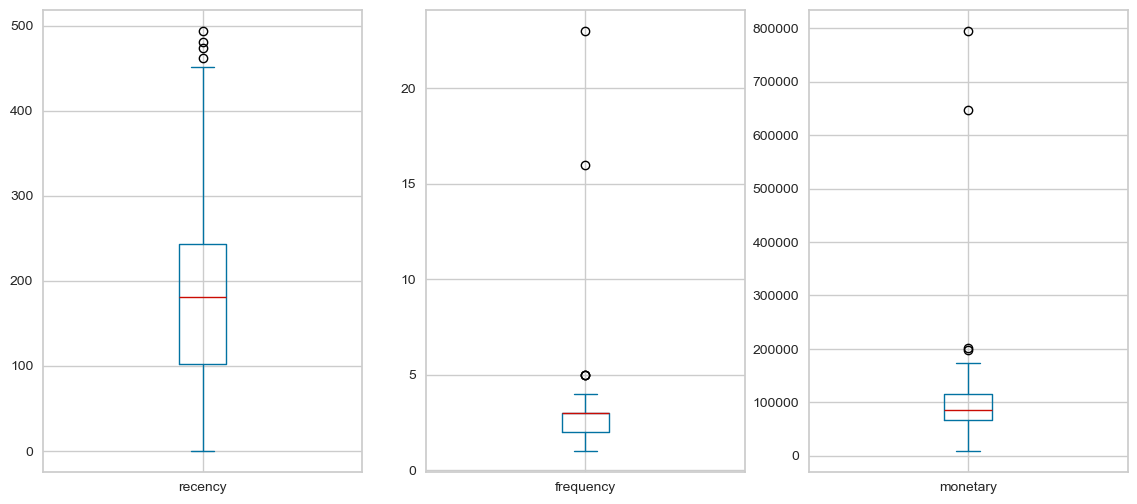

In [122]:
# boxplots
rfm_df.plot(kind='box', subplots=True, figsize=(14,6))
plt.show()

In [123]:
# number of outliers
for rfm_col in rfm_cols:
    # calculate iqr
    col = rfm_df[rfm_col]
    q1, q3 = col.quantile([.25, .75])
    iqr = q3 - q1

    # find outliers
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    l_outliers = (col < lower).sum()
    u_outliers = (col > upper).sum()

    # display
    print('-'*30)
    print(rfm_col.upper())
    print(f'\nNumber of outliers: {l_outliers + u_outliers}')
    print(f'Upper: {u_outliers}')
    print(f'Lower: {l_outliers}')
    print('-'*30)

------------------------------
RECENCY

Number of outliers: 4
Upper: 4
Lower: 0
------------------------------
------------------------------
FREQUENCY

Number of outliers: 5
Upper: 5
Lower: 0
------------------------------
------------------------------
MONETARY

Number of outliers: 4
Upper: 4
Lower: 0
------------------------------


### Distribution

In [124]:
# compare percentiles (mainly 95% and 99%)
percentiles = rfm_df.quantile([.25,.5,.75,.9,.95,.99])
display(percentiles)

for col in rfm_cols:

    # calculate top 1% and top 5%
    top_1 = percentiles.loc[0.99, col]
    top_5 = percentiles.loc[0.95, col]

    # display
    print(col.upper())
    print(f'top 1: {top_1}')
    print(f'top 5: {top_5}')
    print(f'99th percentile is {round(top_1/top_5,2)} times greater than 95th percentile')
    print('-'*30)

,recency,frequency,monetary
0.25,101.75,2.00,66129.0075
0.50,181.00,3.00,85360.0000
0.75,243.25,3.00,115616.8825
0.90,385.20,4.00,142846.9580
0.95,448.25,4.45,164639.6515
0.99,482.17,16.63,660892.1819


RECENCY
top 1: 482.1700000000001
top 5: 448.25
99th percentile is 1.08 times greater than 95th percentile
------------------------------
FREQUENCY
top 1: 16.630000000000024
top 5: 4.450000000000003
99th percentile is 3.74 times greater than 95th percentile
------------------------------
MONETARY
top 1: 660892.1819000005
top 5: 164639.65150000007
99th percentile is 4.01 times greater than 95th percentile
------------------------------


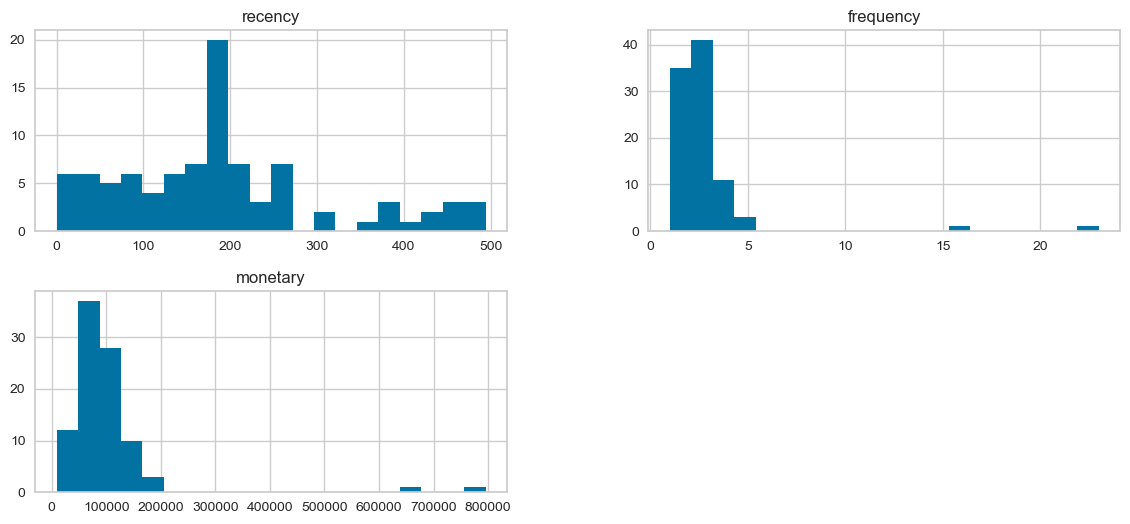

In [125]:
# histograms
rfm_df[rfm_cols].hist(bins=20, figsize=(14,6))
plt.show()

In [126]:
# find skewness and compare mean with median (mean > median --> right skew)
for col in rfm_cols:
    print(col.upper())
    print(f'Skewness: {rfm_df[col].skew()}')
    print(f'\nMean: {rfm_df[col].mean()}')
    print(f'Median: {rfm_df[col].median()}')
    print('-'*30)

RECENCY
Skewness: 0.7692197491282079

Mean: 189.05434782608697
Median: 181.0
------------------------------
FREQUENCY
Skewness: 6.138049494790223

Mean: 3.152173913043478
Median: 3.0
------------------------------
MONETARY
Skewness: 5.392615515812862

Mean: 102632.8191304348
Median: 85360.0
------------------------------


## Check correlation

**Analysis:** 
- <ins>Frequency & Monetary</ins> (r = 0.95) --> strong relationship where more frequent buyers spend more & vise versa
- <ins>Frequency & Recency</ins> (r = -0.35) --> mild relationship where more frequent a buyer, the more recent their last purchase & vise versa
- <ins>Monetary and Recency</ins> (r = -0.31) --> mild relationship where higher spending customers have purchased more recently and vise versa

Overall:
- There is multicollinearity--> recency gives independent information while frequency and monetary have high multicollinearity
- High correlation between frequency and monetary is expected and meaningful in RFM analysis --> real business relationship

In [127]:
# check correlation matrix
rfm_df.corr()

,recency,frequency,monetary
recency,1.000000,-0.347882,-0.309187
frequency,-0.347882,1.000000,0.953394
monetary,-0.309187,0.953394,1.000000


## Transforming & Scaling

**Analysis**

Recency:
- mild right skew (0.769) so light transformation with square root (could have left as is though)
- After transformation: nearly normal with mild right skew 0.210

Frequency:
- heavy right skew (6.138) so log transformation (log1p) for long right tail and to reduce outlier dominance
- After transformation: moderate right skew (3.02) but acceptable for clustering. Over transforming can distort natural relationship between customers (most purchase infrequently while some are very active) and reduce interpretability
- Box-Cox transformation--> does reduce skew to -0.257 BUT it is sensitive to outliers and reduces interpretatibility

Monetary:
- heavy right skew (5.393) so log transformation (log1p) for long right tail and to reduce outlier dominance
- After transformation: nearly normal with mild right skew 0.186

### Transforming all columns

In [128]:
# function: get quick distribution view
def check_distribution(col, b_vs_a='before'):
    # before or after display
    if b_vs_a.upper() == 'BEFORE':
        print('before transformation...')
    else:
        print('after transformation...')
    
    # check skewness
    print(f'\nSkewness: {col.skew()}')

    # display histogram
    col.hist(bins=20)
    plt.show()

------------------------------RECENCY------------------------------
before transformation...

Skewness: 0.7692197491282079


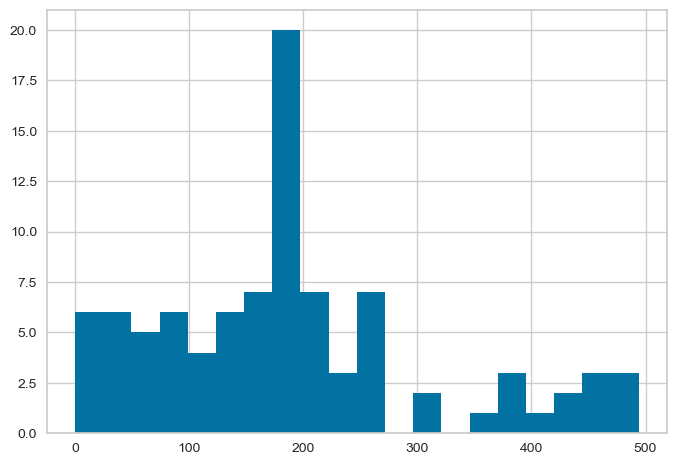

after transformation...

Skewness: 0.21093799139075875


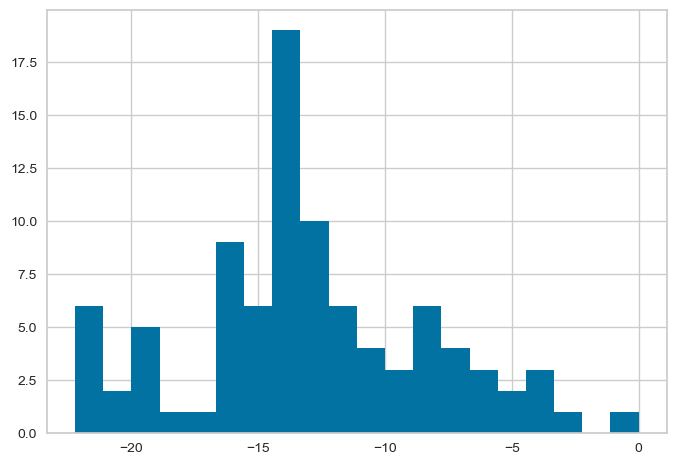

------------------------------FREQUENCY------------------------------
before transformation...

Skewness: 6.138049494790223


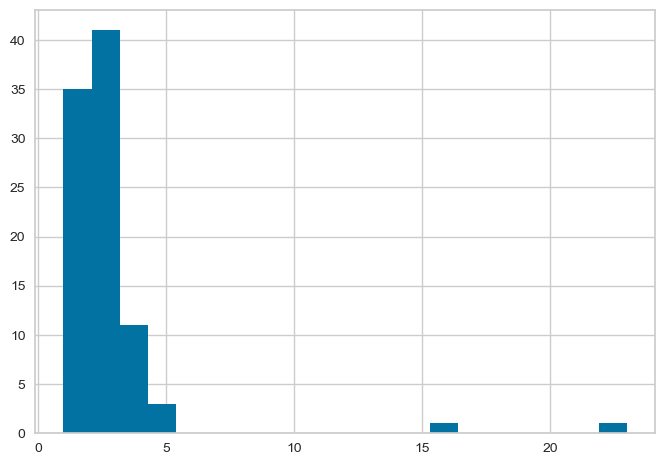

after transformation...

Skewness: 3.0203428432311634


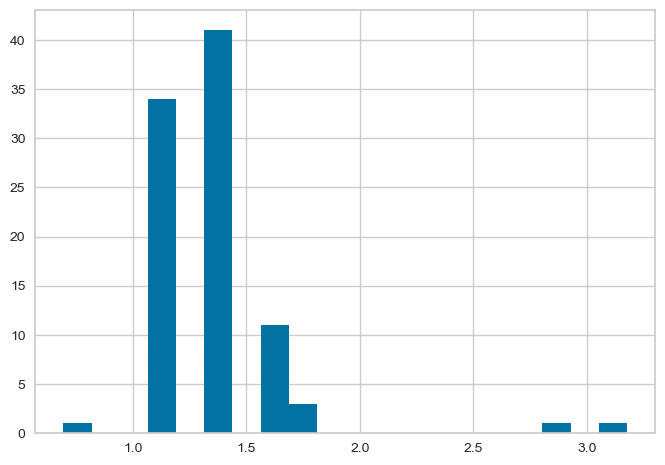

------------------------------MONETARY------------------------------
before transformation...

Skewness: 5.392615515812862


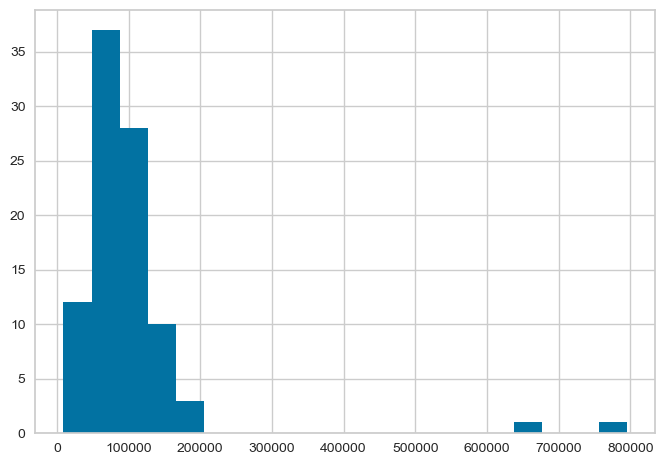

after transformation...

Skewness: 0.18604987274083093


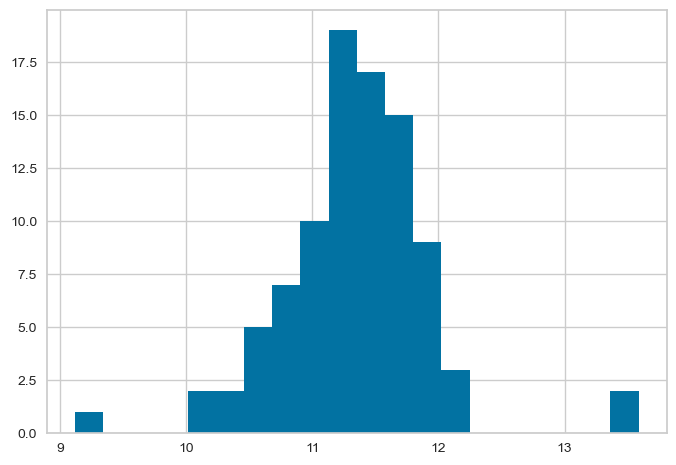

In [129]:
# set up new df
transformed_rfm_df = rfm_df.copy()

# transform columns accordingly
transformed_rfm_df['recency'] = -np.sqrt(transformed_rfm_df['recency']) #inversing sign so higher=better
transformed_rfm_df['monetary'] = np.log1p(transformed_rfm_df['monetary'])
transformed_rfm_df['frequency'] = np.log1p(transformed_rfm_df['frequency'])

# check og distributions vs new
for col_name in ['recency','frequency', 'monetary']:
    print('-'*30 + col_name.upper() + '-'*30)
    check_distribution(rfm_df[col_name], b_vs_a='before')
    check_distribution(transformed_rfm_df[col_name], b_vs_a='after')

### Scale Data

Using RobustScaler, because it has low outlier sensitivity (ignores tails beyond IQR)

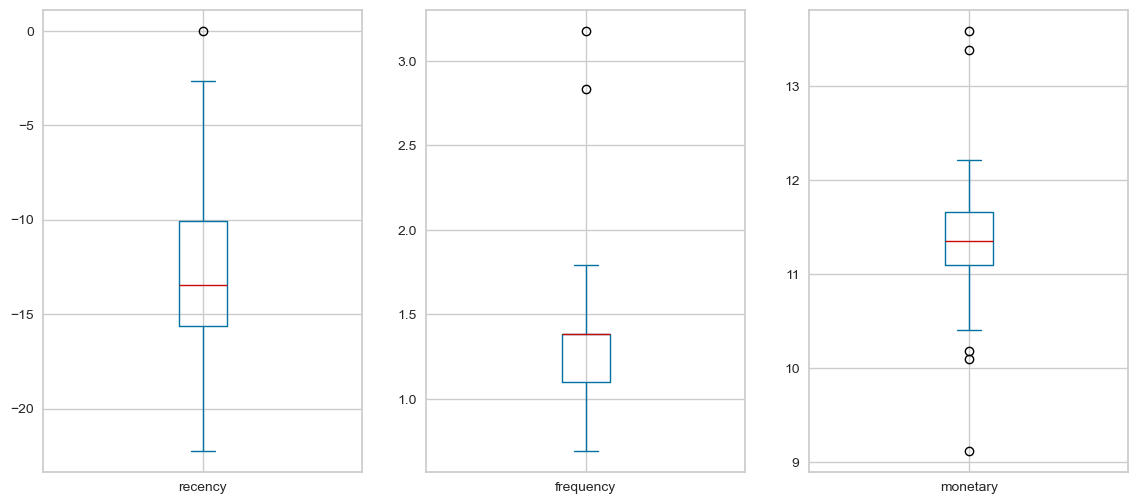

In [130]:
# quick outliers check
transformed_rfm_df.plot(kind='box', subplots=True, figsize=(14,6))
plt.show()

In [131]:
# normalize data
scaler = RobustScaler()
scaled_rfm = scaler.fit_transform(transformed_rfm_df)

In [132]:
# convert to df
scaled_rfm_df = pd.DataFrame(
    scaled_rfm,
    columns=rfm_cols,
    index=rfm_df.index
)

scaled_rfm_df.head()

,recency,frequency,monetary
customer_id,,,
1,-0.013453,0.00000,0.590302
2,-0.207062,-1.00000,0.288787
3,-0.046767,0.77566,0.595074
4,-1.369597,0.00000,0.921884
5,0.356538,0.77566,0.621261


# Modeling
---

## Functions

### get k model

In [166]:
# function: get k means or k medoids/pam model (no fitting)
def get_k_model(
    k: int = 1,
    get_base: bool = False,
    get_pam: bool = False
):
    '''
    - get k means model by default or set get_pam to true to get k-medoids/pam model
    - get base model without k specified or specify k

    Parameters
    ----------
    k: optional specified k value for when you want model with k specified returned
    get_base: get base model without k if set to true and without k if set to false (default is false)
    get_pam: get k-medoids model if set to true or get k-means model if set to false (default is false)
    
    '''
    # set up random state
    random_state = 42

    # set up base depending on model
    if get_pam:
        # init = 'k-mediods++'
        # method = 'pam'
        # metric = 'euclidean'

        base = KMedoids(
            init='k-medoids++',
            method='pam',
            metric='euclidean',
            random_state=random_state
        )
    else:
        # init = 'k-means++'
        # n_init = 50

        base = KMeans(
            init='k-means++',
            n_init=50,
            random_state=random_state
        )
    
    # return
    return base if get_base else base.set_params(n_clusters=k)

### get elbow plot

In [140]:
# function: elbow plot with different metric options
def get_elbow_plot(
        df: pd.DataFrame, 
        k_vals: tuple = (2,10), 
        metric:str = 'distortion',
        use_pam: bool = False
):
    '''
    get elbow plot using one of the metrics: distortion, silhouette, calinski_harabasz
    default is distortion (returns inertia values)

    ---
    see best k value (uses default knee detector--largest perpendicular distance--to find 
        the smallest k that captures most of the structure before diminishing returns set in)
    '''
    # get base model
    model = get_k_model(get_base=True, get_pam=use_pam)
    display(model)

    # get k values 
    k = k_vals

    # build hidden matplotlib canvas
    fig, ax = plt.subplots()
    plt.close(fig)

    # run yellowbrick on canvas
    viz = KElbowVisualizer(
        model,
        k=k_vals,
        metric=metric,
        timings=False,
        ax=ax
    )

    viz.fit(df)
    
    # convert results into plot
    elbow_df = pd.DataFrame({
        'k': viz.k_values_,
        'score': viz.k_scores_
    })

    print(f'Elbow at k = {viz.elbow_value_} with score = {viz.elbow_score_}')
    elbow_plot = elbow_df.hvplot.line(
        x='k',
        y='score',
        grid=True,
        title=f'Elbow Plot ({metric.capitalize()}) with {'PAM' if use_pam else 'K-Means'}'
    )

    return elbow_plot

### get silhouette grid

In [145]:
# function: plot silhouette scores
def plot_silhouettes(k_vals, df, use_pam: bool=False):
    '''
    gets one silhouette plot per k and returns dict of k value with average silhouette score
    '''
    # set up main figure
    n_cols = 2  #plots per row
    n_rows = math.ceil(len(k_vals) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12,6), squeeze=False)

    # get mean silhouette scores per k
    mean_scores = {}

    for idx, k in enumerate(k_vals):
        row, col = divmod(idx, n_cols)
        k_model = get_k_model(k, get_pam=use_pam)
        viz = SilhouetteVisualizer(k_model, colors='yellowbrick', ax=axes[row][col])
        viz.fit(df)
        mean_scores[k] = viz.silhouette_score_
    
    # hide any empty sub-plots
    for j in range(len(k_vals), n_rows * n_cols):
        r,c = divmod(j, n_cols)
        axes[r][c].axis('off')
    
    # display
    plt.tight_layout()
    plt.show()

    # return scores
    return mean_scores

In [149]:
# helper: pick a column by index or name
def _col(mat, key): 
    return mat[key] if isinstance(key, str) else mat.iloc[:, key]

# function: plot silhouette scores 
def silhouette_diagnostic(
        scaled_data: pd.DataFrame,
        k_vals=range(2,6),
        use_pam: bool=False,
        x_axis=0,
        y_axis=1
):
    '''
    shows one silhouette and cluster plot per k value and returns dict of k value with average silhouette score

    Parameters
    ----------
    scaled_data: scaled/transformed dataframe
    k_vals: optional list of potential number of segments
    x_axis, y_axis: optional features to plot in scatter plot (default select first two features in dataframe)
    '''

    # if df, update into numpy array
    data = scaled_data.values if isinstance(scaled_data, pd.DataFrame) else scaled_data
    plot_data = scaled_data
  
    # collect results here
    mean_scores = {}

    # get plots for each k value
    for k in k_vals:
        # fresh figure with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

        # --- silhouette subplot -------------------------------------------------
        # set x and y axis lim
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(data) + (k + 1) * 10])

        # fit k means model
        clusterer = get_k_model(k, get_pam=use_pam)
        labels = clusterer.fit_predict(data)

        # store avg silhouette score in dict
        silhouette_avg = silhouette_score(data, labels)
        mean_scores[k] = silhouette_avg
        
        # per sample silhouettes
        sample_vals = silhouette_samples(data, labels)

        # plot each cluster's silhouette horizontally
        y_lower = 10
        for i in range(k):
            # aggregate scores for each cluster (i)
            ith_vals = np.sort(sample_vals[labels == i])
            size_i = ith_vals.shape[0]
            y_upper = y_lower + size_i

            # color
            color = cm.nipy_spectral(float(i) / k)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0, ith_vals,
                facecolor=color, edgecolor=color, alpha=0.7
            )

            # label clusters with number
            ax1.text(-0.05, y_lower + 0.5 * size_i, str(i))

            # new y_lower for next plot
            y_lower = y_upper + 10

        # title/labels
        ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
        ax1.set_title(f'Silhouette plot (k={k}) with {'PAM' if use_pam else 'K-Means'}')
        ax1.set_xlabel('Silhouette coefficient')
        ax1.set_ylabel('Cluster label')
        ax1.set_yticks([])
        ax1.set_xticks(np.linspace(-0.1, 1.0, 7))

        # --- scatter plot ----------------------------------------------------
        colors = cm.nipy_spectral(labels.astype(float) / k)
        ax2.scatter(
            _col(plot_data, x_axis), 
            _col(plot_data, y_axis), 
            marker='.', s=150, alpha=0.7, c=colors, edgecolor='k'
        )

        # get cluster centers and plot
        centers = clusterer.cluster_centers_
        x_idx = plot_data.columns.get_loc(x_axis) if isinstance(x_axis, str) else x_axis
        y_idx = plot_data.columns.get_loc(y_axis) if isinstance(y_axis, str) else y_axis

        ax2.scatter(
            centers[:, x_idx], centers[:, y_idx],
            marker='o', c='white', s=210, edgecolor='k'
        )
        for i, c in enumerate(centers):
            ax2.scatter(
                c[x_idx], c[y_idx],
                marker=f'${i}$', s=50, color='black'
            )
        
        # labels
        ax2.set_title('Clustered data')
        ax2.set_xlabel(f'Feature {x_axis}')
        ax2.set_ylabel(f'Feature {y_axis}')
        
        # show plot
        plt.show()

    # return dict of scores
    return mean_scores

### get scores

In [ ]:
def get_cluster_scores(
    df: pd.DataFrame,
    k_vals=range(2,6),
    use_pam: bool=False,
    metric: Literal['silhouette', 'ch_score', 'davies_bouldin', 'inertia'] = 'davies_bouldin'
): 
    '''
    score diffent cluster counts by one of three different metrics
    returns dict of k value with score

    Parameters
    ----------
    df: scaled/transformed dataframe
    k_vals: optional list of potential number of segments
    use_pam: optional use k-medoids/pam model instead of k-means by setting true (default k-means model)
    metric: optional choice of metric to score each k value by (default is davies_bouldin)
    '''
    # make case insensitive
    metric = metric.lower()

    # store results
    scores = []

    for k in k_vals:

        # get model and predictions
        k_model = get_k_model(k, get_pam=use_pam).fit(df)
        labels = k_model.labels_

        # score accordingly
        if metric == 'silhouette':
            score = metrics.silhouette_score(df, labels)
        elif metric == 'ch_score':
            score = metrics.calinski_harabasz_score(df, labels)
        elif metric == 'davies_bouldin':
            score = metrics.davies_bouldin_score(df, labels)
        elif metric == 'inertia':
            score = k_model.inertia_
        else:
            raise ValueError("Metric must be one of the following: silhouette, ch_score, davies_bouldin")
        
        # add to scores
        scores.append({
            'k': k,
            'score': score
        })
    
    print(f'Finished scoring by {metric}')

    return scores  

### get 3d plot

In [170]:
# function: get 3d plot
def get_3d_plot(
        df: pd.DataFrame,
        column_names: List[str] = None,
        color_by: str = 'segment'
):
    
    # get list of columns
    cols = list(df.columns) if column_names is None else column_names

    # create 3d scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # plot
    ax.scatter(
        df[cols[0]], df[cols[1]], df[cols[2]],
        c=df[color_by],
        cmap='viridis',
        marker='o'
    )

    # labels
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    ax.set_zlabel(cols[2])
    ax.zaxis.labelpad=-0.7

    plt.show()

### get k means segments

In [ ]:
# function: get best k value based on metric to do clusters and return segment labels and plot
def get_k_segments(
        scaled_data: pd.DataFrame,
        k_values: List[int], 
        use_pam: bool=False,
        og_data: pd.DataFrame | None=None,
        metric: Literal['silhouette', 'ch_score'] = 'silhouette', 
        x_val: str | None = None, 
        y_val: str | None = None
) -> Tuple[pd.DataFrame, 'hvplot.core.chart.Chart']:
    
    '''
    choose the best k by metric (silhouette or calinksi-harabasz), run k means, get segment labels, and return
        - dataframe with segment labels
        - scatter plot color coded by segment labels
    
    Parameters
    ----------
    scaled_data: scaled/transformed dataframe
    use_pam: optional use k-medoids/pam model instead of k-means by setting true (default k-means model)
    og_data: dataframe to attach predictions to and use for plotting (transformed or og data)
    k_values: list of potential number of segments
    metric: use silhouette or calinksi-harabasz score to get best number of segments
    x_val, y_val: optional features to plot in scatter plot (default select first two features in dataframe)
    '''
    # get copy of df
    df = scaled_data.copy()
    og_df = og_data.copy() if og_data is not None else scaled_data.copy()

    # check df if it has minimum 2 cols and get axis for plot
    if x_val is None or y_val is None:
        if df.shape[1] < 2:
            raise ValueError(f'⚠ VALUE ERROR: DataFrame, {df}, must have at least 2 columns')
        cols = list(df.columns)
        x_val = x_val or cols[0]
        y_val = y_val or cols[1]

    
    # score all k values
    k_scores = []

    for k in k_values:
        # get scores
        k_model = get_k_model(k, get_pam=use_pam).fit(df)
        labels = k_model.labels_

        # score based on metric selected
        if metric.lower() == 'silhouette':
            score = metrics.silhouette_score(df, labels)
        elif metric.lower() == 'ch_score':
            score = metrics.calinski_harabasz_score(df, labels)
        else:
            raise ValueError(f'⚠ VALUE ERROR: metric entered is "{metric}" when metric needs to be either: \n\tsilhouette \n\tch_score')
            
        k_scores.append({
            'k': k,
            'score': score
        })
        
    # display best score
    print(k_scores)
    top_k_score = max(k_scores, key=lambda item: item.get('score'))
    best_k, best_score = top_k_score['k'], top_k_score['score']
    print(f'Best k value = {best_k} ({metric} score = {best_score:.3f})')

    # get segments based on best k value
    k_model = get_k_model(best_k).fit(df)
    predictions = k_model.labels_

    # add labels to original dataframe
    labeled_og_df = og_df.assign(segment=predictions)

    # get scatter plot
    if og_df.shape[1] < 3:
        scatter_plot = labeled_og_df.hvplot.scatter(
            x=x_val,
            y=y_val,
            by='segment',
            hover_cols='all'
        )
        display(scatter_plot)
    else:
        scatter_plot = get_3d_plot(labeled_og_df)
    

    # return df
    return labeled_og_df, scatter_plot

## Model: K-Means

### Elbow plot (k=3 --> 2,3,4)

**Narrows k down to k=2,3,4**
- Based on distortion, beyond k=3 the curve flattens
- Not worth looking at larger cluster amounts (2 <= k <= 4)

In [144]:
# get elbow
get_elbow_plot(scaled_rfm_df)

KMeans(n_init=50, random_state=42)

Elbow at k = 3 with score = 103.48672228072019


:Curve   [k]   (score)

### Silhouette analysis

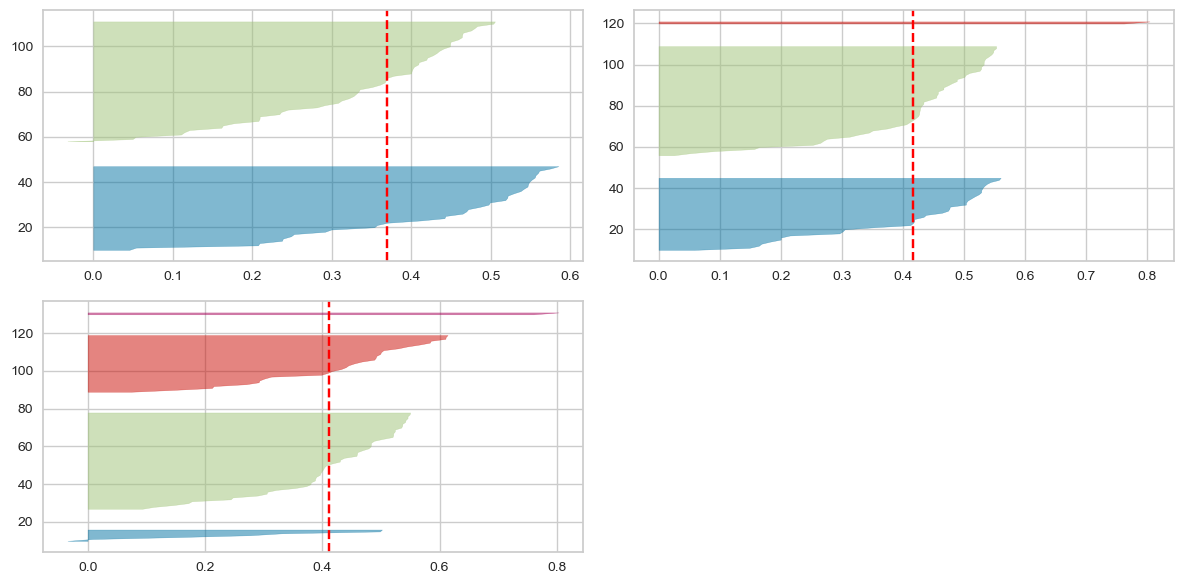

{2: 0.36990919003230793, 3: 0.41665886359331117, 4: 0.4123376666829266}

In [146]:
# plot silhouette scores
plot_silhouettes([2,3,4],scaled_rfm_df)

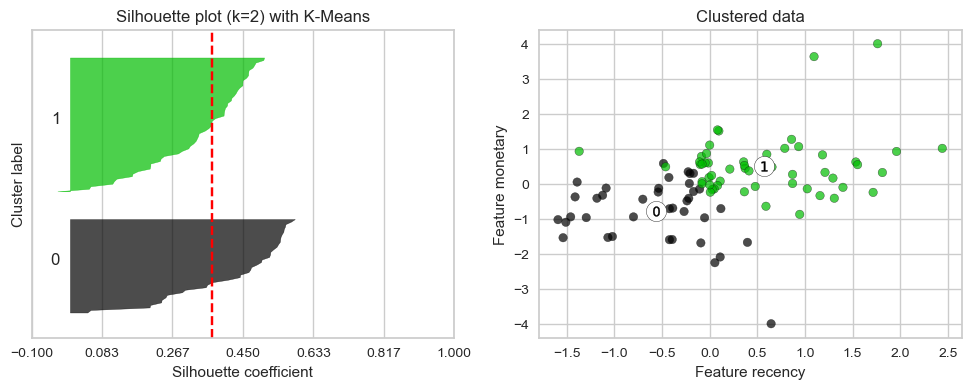

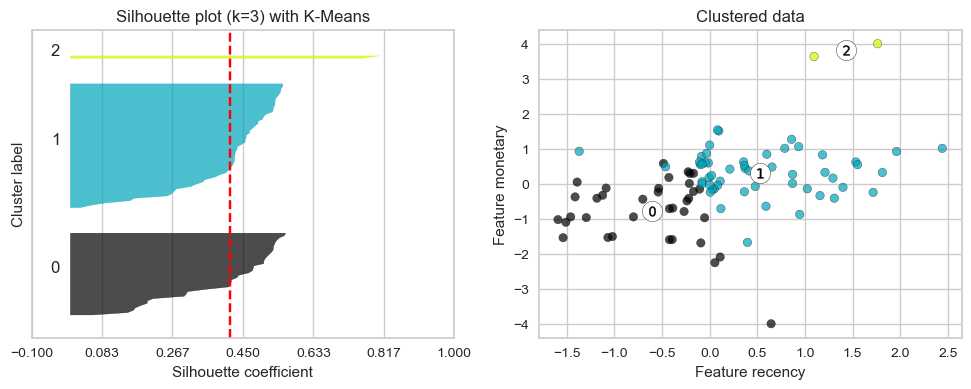

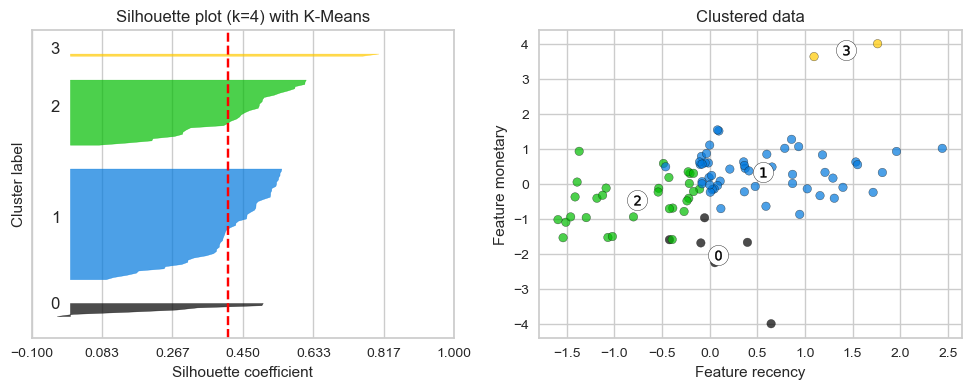

{2: 0.36990919003230793, 3: 0.41665886359331117, 4: 0.4123376666829266}

In [150]:
silhouette_diagnostic(scaled_data=scaled_rfm_df, x_axis='recency', y_axis='monetary', k_vals=[2,3,4])

### Check scores

**Best k is 3**--> primarily based on knee detector and top scores

Silhouette
- Knee detector--> k=3
- Top 2 (peak)--> k= 3, k=4

CH index
- Knee detector--> k=3
- Top 2 (peak)--> k=3, k=5

Davies Bouldin
- Top 2 (lowest)--> k=3, k=4

In [153]:
# check davies bouldin score --> top 2 (k=3, k=4)
get_cluster_scores(scaled_rfm_df)

Finished scoring by davies_bouldin


[{'k': 2, 'score': 1.0036030335706694},
 {'k': 3, 'score': 0.7259488361534786},
 {'k': 4, 'score': 0.7298246722474709},
 {'k': 5, 'score': 0.8770730210769188}]

In [154]:
# find best k using knee detector --> k=3
display(get_elbow_plot(df=scaled_rfm_df, metric='silhouette'))

# check silhouette score--> top 2 (k=3, k=4)
get_cluster_scores(df=scaled_rfm_df, metric='silhouette')

KMeans(n_init=50, random_state=42)

Elbow at k = 3 with score = 0.41665886359331117


:Curve   [k]   (score)

Finished scoring by silhouette


[{'k': 2, 'score': 0.36990919003230793},
 {'k': 3, 'score': 0.41665886359331117},
 {'k': 4, 'score': 0.4123376666829266},
 {'k': 5, 'score': 0.35943853230118133}]

In [155]:
# check ch_score --> top 2 (k=3)
display(get_elbow_plot(df=scaled_rfm_df, metric='calinski_harabasz', k_vals=(2,5)))

# check ch_score --> top 2 (k=3, k=5)
get_cluster_scores(df=scaled_rfm_df, metric='ch_score', k_vals=range(2,5))

KMeans(n_init=50, random_state=42)

Elbow at k = 3 with score = 78.94361684166773


:Curve   [k]   (score)

Finished scoring by ch_score


[{'k': 2, 'score': 49.639258977262585},
 {'k': 3, 'score': 78.94361684166773},
 {'k': 4, 'score': 72.41809070859473}]

### Get segments --> k=3

[{'k': 3, 'score': 0.41665886359331117}]
Best k value = 3 (silhouette score = 0.417)


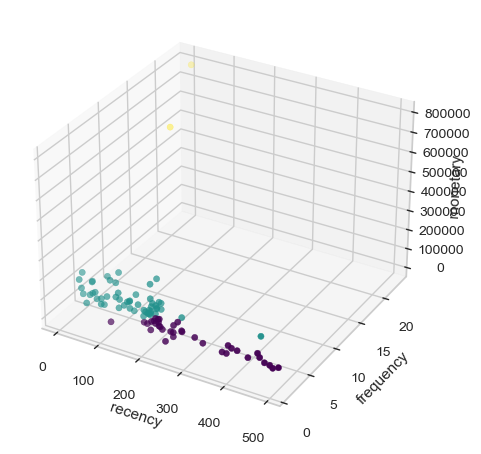

In [175]:
# select best k
k_options = [3]

# get segments for silhouette k = 3
full_3segments_df = get_k_segments(
    scaled_data=scaled_rfm_df, og_data=rfm_df, 
    k_values=k_options, metric='silhouette'
)[0]

## Model: K-Medoids (PAM)

### Elbow plot (k=3 --> 2,3,4)

**Narrows k down to k=2,3,4**
- Based on distortion, beyond k=3 the curve flattens
- Not worth looking at larger cluster amounts (2 <= k <= 4)

In [167]:
get_elbow_plot(scaled_rfm_df, use_pam=True)

KMedoids(init='k-medoids++', method='pam', random_state=42)

Elbow at k = 3 with score = 103.63895162550833


:Curve   [k]   (score)

### Silhouette analysis

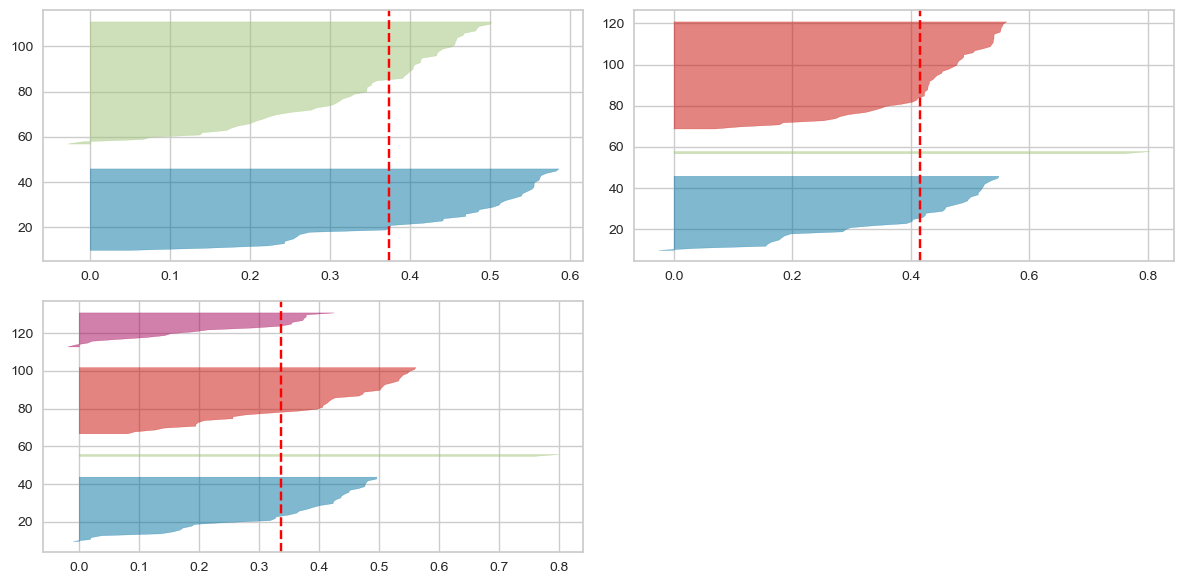

{2: 0.37354720212798087, 3: 0.41611964265077317, 4: 0.3369098626935839}

In [168]:
# plot silhouette scores
plot_silhouettes([2,3,4],scaled_rfm_df, use_pam=True)

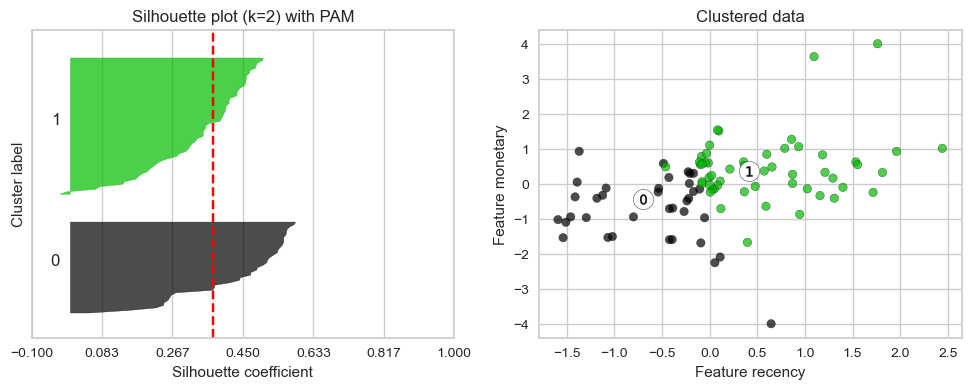

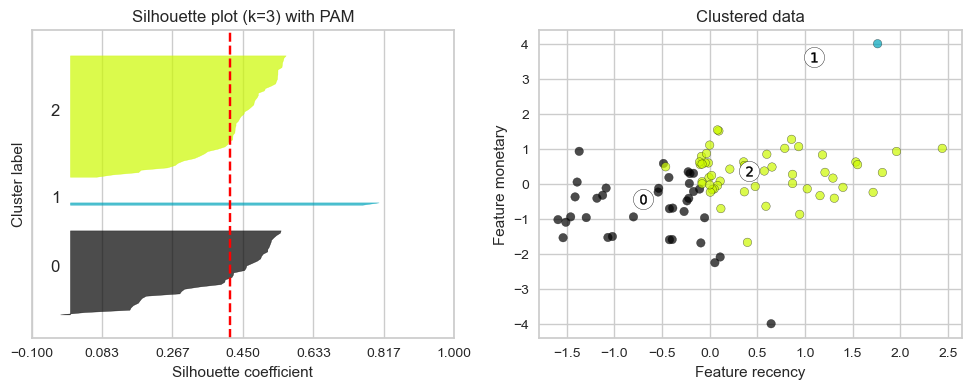

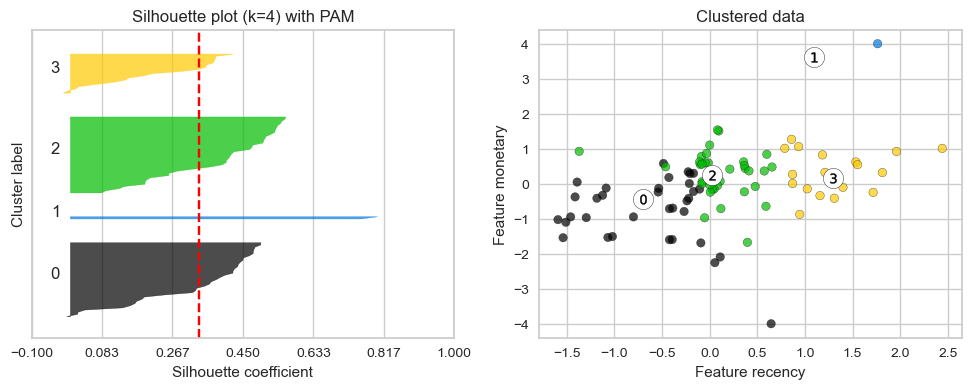

{2: 0.37354720212798087, 3: 0.41611964265077317, 4: 0.3369098626935839}

In [169]:
silhouette_diagnostic(scaled_data=scaled_rfm_df, use_pam=True, x_axis='recency', y_axis='monetary', k_vals=[2,3,4])

### Check scores

**Best k is 3**--> based on knee detector and top scores

Silhouette
- Knee detector--> k=3
- Top 2 (peak)--> k=3, k=2 (k=3 decently higher)

CH index
- Knee detector--> k=3
- Top 2 (peak)--> k=3, k=4 (k=3 decently higher)

Davies Bouldin
- Top 2 (lowest)--> k= 3 (k=4 is too much higher to consider)

In [156]:
# check davies bouldin score --> top (k=3) --> k=4 too high
get_cluster_scores(scaled_rfm_df, use_pam=True)

Finished scoring by davies_bouldin


[{'k': 2, 'score': 0.9937649185243339},
 {'k': 3, 'score': 0.7313497746758042},
 {'k': 4, 'score': 0.9411779391458788},
 {'k': 5, 'score': 0.9753629386155648}]

In [158]:
# find best k using knee detector --> k=3
display(get_elbow_plot(df=scaled_rfm_df, use_pam=True, metric='silhouette'))

# check silhouette score--> top 2 (k=3, k=2)
get_cluster_scores(df=scaled_rfm_df, use_pam=True, metric='silhouette')

KMedoids(init='k-medoids++', method='pam', random_state=42)

Elbow at k = 3 with score = 0.41611964265077317


:Curve   [k]   (score)

Finished scoring by silhouette


[{'k': 2, 'score': 0.37354720212798087},
 {'k': 3, 'score': 0.41611964265077317},
 {'k': 4, 'score': 0.3369098626935839},
 {'k': 5, 'score': 0.3319658222605043}]

In [159]:
# check ch_score --> top 2 (k=3)
display(get_elbow_plot(df=scaled_rfm_df, use_pam=True, metric='calinski_harabasz', k_vals=(2,5)))

# check ch_score --> top 2 (k=3, k=4)
get_cluster_scores(df=scaled_rfm_df, use_pam=True, metric='ch_score', k_vals=range(2,5))

KMedoids(init='k-medoids++', method='pam', random_state=42)

Elbow at k = 3 with score = 78.76229755374221


:Curve   [k]   (score)

Finished scoring by ch_score


[{'k': 2, 'score': 49.210904658036185},
 {'k': 3, 'score': 78.76229755374221},
 {'k': 4, 'score': 68.84805653749258}]

### Get segments--> k=3

[{'k': 3, 'score': 0.41611964265077317}]
Best k value = 3 (silhouette score = 0.416)


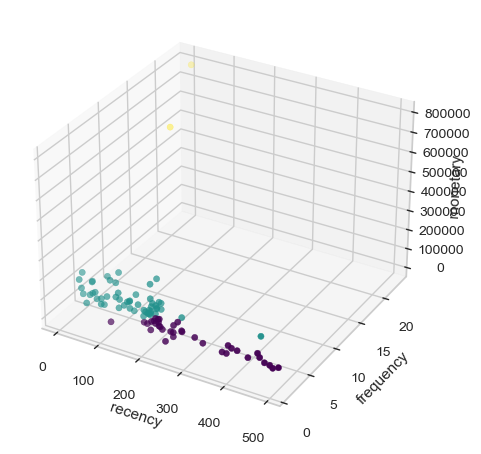

In [176]:
# select best k
k_options = [3]

# get segments for silhouette k = 3
pam_segments_df = get_k_segments(
    scaled_data=scaled_rfm_df, use_pam=True, og_data=rfm_df, 
    k_values=k_options, metric='silhouette'
)[0]

# Best Model
---

## Compare both models

### Comparison Plots

----------------------------------------------K-Means-----------------------------------------------
[{'k': 3, 'score': 0.41665886359331117}]
Best k value = 3 (silhouette score = 0.417)


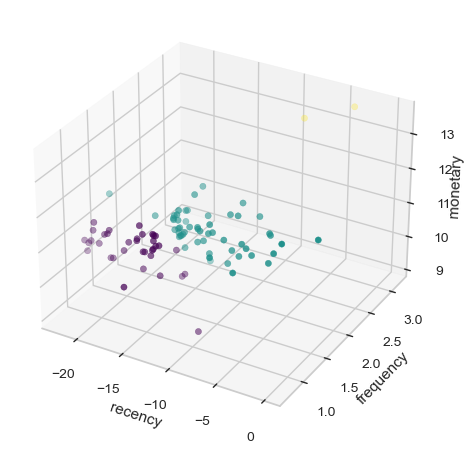

None

------------------------------------------------PAM-------------------------------------------------
[{'k': 3, 'score': 0.41611964265077317}]
Best k value = 3 (silhouette score = 0.416)


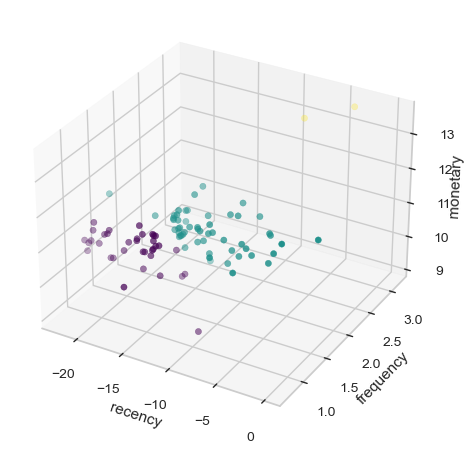

None

----------------------------------------------K-Means-----------------------------------------------


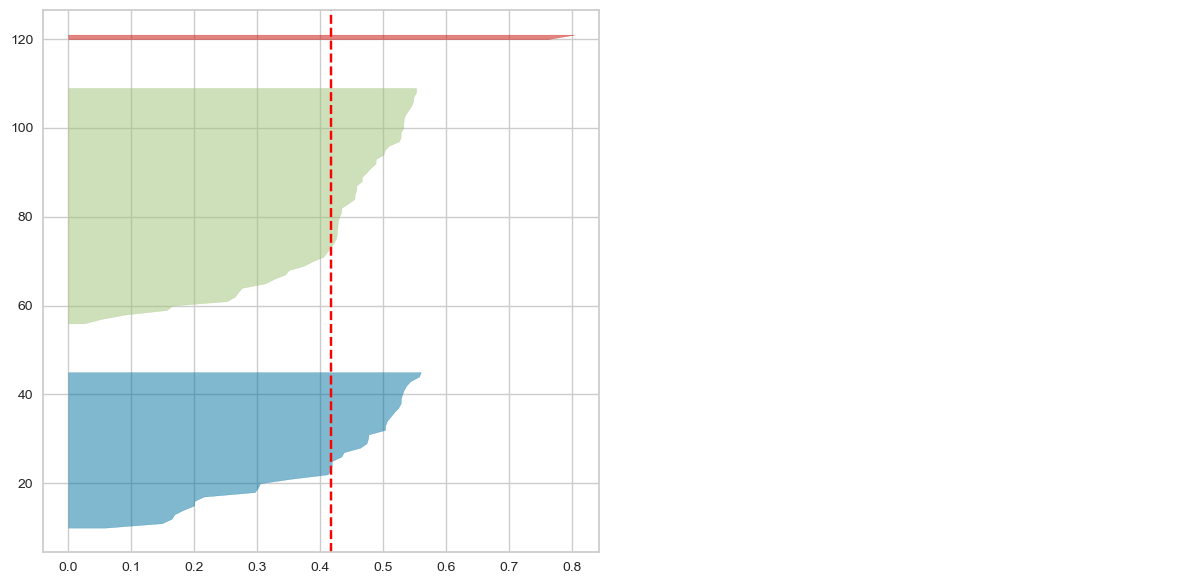

------------------------------------------------PAM-------------------------------------------------


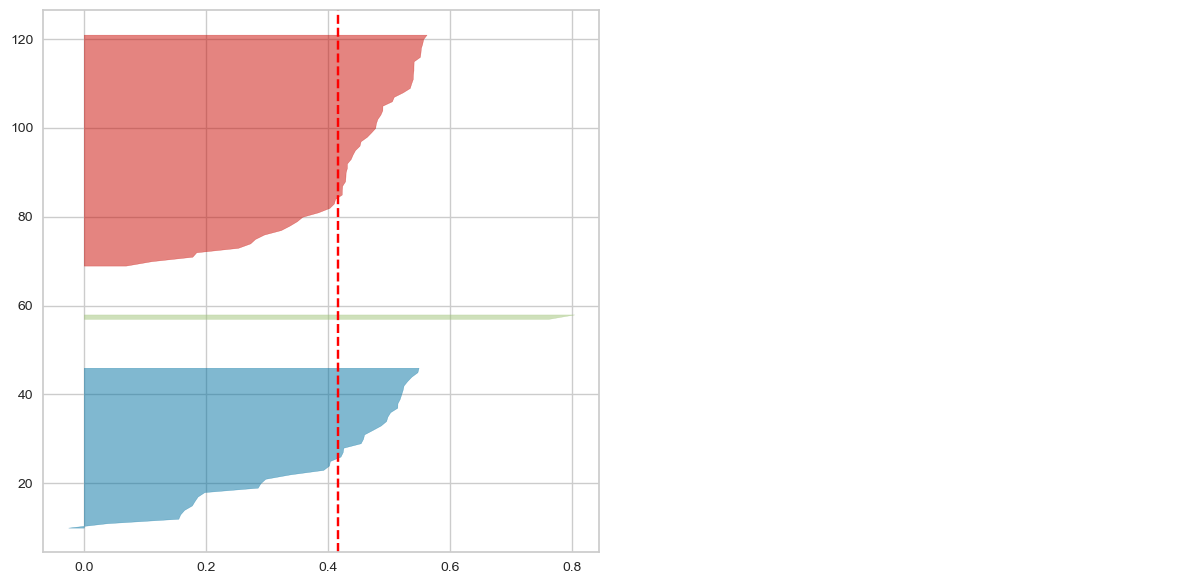

In [181]:
k_option= 3
count = 0
titles=['K-Means', 'PAM']

# ------- scatter plot -------------------------------------------
for title in titles:
    # display title
    title = titles[0] if count == 0 else titles[1]
    print(title.center(100, '-'))
    pam_bool = True if title == 'PAM' else False

    # display plot
    display(get_k_segments(
        scaled_data=scaled_rfm_df,
        og_data=transformed_rfm_df,
        use_pam=pam_bool,
        k_values=[k_option],
        metric='silhouette'
    )[1])

    count+=1

# ------- silhouette plot -------------------------------------------
count = 0
for title in titles:
    # display title
    title = titles[0] if count == 0 else titles[1]
    print(title.center(100, '-'))
    pam_bool = True if title == 'PAM' else False

    plot_silhouettes([k_option], scaled_rfm_df, use_pam=pam_bool)
    count+=1

### Compare Scores

In [182]:
# setup variables
metric_lst = ['silhouette', 'ch_score', 'davies_bouldin', 'inertia']
scores_df = pd.DataFrame(columns=metric_lst)
count = 0

# loop through dfs
for title in titles:

    # display progress
    print(f'\nScoring {title} Model...')
    title = titles[0] if count == 0 else titles[1]
    pam_bool = True if title == 'PAM' else False
    
    # new row for scores
    scores = {}

    # get values for each metric
    for metric in metric_lst:
        m_value = get_cluster_scores(
            df=scaled_rfm_df,
            use_pam=pam_bool,
            k_vals=[k_option],
            metric=metric
        )[0]['score']

        # add to dict
        scores[metric] = m_value
    
    # add dict as new row in df
    scores_df.loc[title] = scores
    
    count += 1

display(scores_df)


Scoring K-Means Model...
Finished scoring by silhouette
Finished scoring by ch_score
Finished scoring by davies_bouldin
Finished scoring by inertia

Scoring PAM Model...
Finished scoring by silhouette
Finished scoring by ch_score
Finished scoring by davies_bouldin
Finished scoring by inertia


,silhouette,ch_score,davies_bouldin,inertia
K-Means,0.416659,78.943617,0.725949,103.486722
PAM,0.416120,78.762298,0.731350,84.945236


## Best Model --> TBD

PCA Model --> outperforms against full scaled data model on all metrics; may be due to it better handling multicollinearity issue between Frequency and Monetary features
- <ins>Higher Silhouette Score</ins>: on average each data point is better matched to its own cluster indicating better defined and separated clusters; also seen in silhouette plot where there are less individual errors for points (smaller negative scores in green cluster) meaning less overlapping and better defined green cluster
- <ins>Higher CH Index</ins>: better ratio of clusters being separated from each other while being tightly grouped clusters--low internal variance--indicating better defined and distinct clusters
- <ins>Lower Davies-Bouldin Index</ins>: lower average similarity between each cluster and it's closest cluster indicating better separated and more compact clusters
- <ins>Lower inertia</ins>: more compact clusters--data points are closer to the center of their cluster

In [108]:
# store best model segment labels
rfm_segments_df = full_3segments_df.copy()
%store rfm_segments_df

Stored 'rfm_segments_df' (DataFrame)
